In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
pdf = pd.read_csv('../../masked/patients_info.csv', index_col=0)
pdf['Molecular_Subtype'] = pdf['HER2_Status']+pdf['ER_Status']

In [3]:
# protein expression
dia = pd.read_csv('../../masked/dia.csv', index_col=0)
dia['Molecular_Subtype'] = dia.index.map(pdf['Molecular_Subtype'])
dia['pCR'] = dia.index.map(pdf['pCR'])

# phosphoprotein expression
pp = pd.read_csv('../../masked/pp.csv', index_col=0)
pp['Molecular_Subtype'] = pp.index.map(pdf['Molecular_Subtype'])
pp['pCR'] = pp.index.map(pdf['pCR'])

In [4]:
def diff(tmp, col, value, method):
    from scipy.stats import ranksums, ttest_ind
    from sklearn.metrics import roc_auc_score
    symbol = []
    res = []
    median_case = []
    median_ctr = []
    case = tmp[tmp[col]==value]
    ctr = tmp[tmp[col]!=value]
    
    for i in tmp.drop(columns=col).columns:
        if method == 'rank':
            res.append(ranksums(case[i],ctr[i]).pvalue)
        elif method == 'ttest':
            res.append(ttest_ind(case[i],ctr[i]).pvalue)
        elif method == 'auc':
            res.append(roc_auc_score(tmp[col]==value, tmp[i]))
            
        symbol.append(i)
        median_case.append((case[i]).median())
        median_ctr.append((ctr[i]).median())
        
    all_df = pd.DataFrame()
    all_df['SYMBOL'] = symbol
    all_df['Mean_Case'] = median_case
    all_df['Mean_Ctr'] = median_ctr
    all_df['Diff'] =  all_df['Mean_Case']-all_df['Mean_Ctr']
    all_df['Result'] = res
    
    return all_df

deres = {}
for i in dia['Molecular_Subtype'].unique():
    dfs = dia[dia['Molecular_Subtype']==i].sort_values('pCR').drop(columns=['Molecular_Subtype'])
    
    sig_c1 = diff(dfs, 'pCR', 1, 'rank')

    sig_c1 = sig_c1.dropna()

    def findGene(x):
        return x.split('_')[0]
    def findOmics(x):
        return x.split('_')[-1]

    deres[i] = sig_c1.sort_values('Result')
    
dpres = {}
for i in pp['Molecular_Subtype'].unique():
    dfs = pp[pp['Molecular_Subtype']==i].sort_values('pCR').drop(columns=['Molecular_Subtype'])
    
    sig_c1 = diff(dfs, 'pCR', 1, 'rank')

    sig_c1 = sig_c1.dropna()

    def findGene(x):
        return x.split('_')[0]
    def findOmics(x):
        return x.split('_')[-1]

    dpres[i] = sig_c1.sort_values('Result')

In [5]:
BRCA_related = sorted(set(list(pd.read_csv('../../../bionetwork/BRCA_related.genes.csv')['core_genes'])+\
           list(pd.read_csv('../../../bionetwork/BRCA_related.genes.csv')['extended_genes'])))
def check_related(x):
    return x in BRCA_related

PosNeg
Red: 131 Blue: 118
BRCA genes. Red: 6 Blue: 10

NegNeg
Red: 477 Blue: 442
BRCA genes. Red: 44 Blue: 28

PosPos
Red: 68 Blue: 63
BRCA genes. Red: 7 Blue: 4



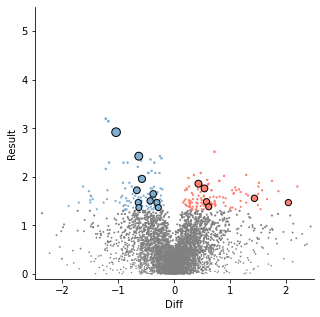

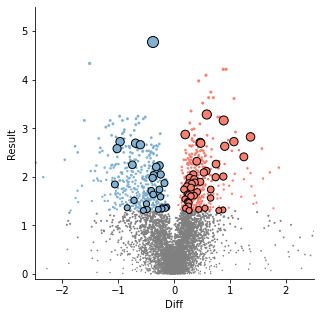

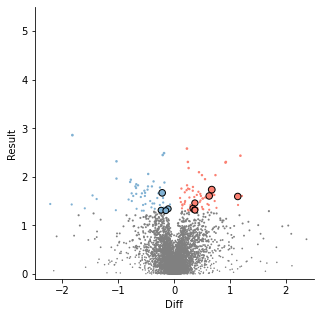

In [6]:
for i in dia['Molecular_Subtype'].unique():
    sig_c1 = deres[i].dropna()[[]]
    sig_c1['Diff'] = deres[i].dropna()['Diff']
    sig_c1['Result'] = deres[i].dropna()['Result']
    sig_c1['GENE'] = deres[i].dropna()['SYMBOL']

    def color(df):    
        return 1*(df['Result']<0.05)*(df['Diff']>0.0) - 1*(df['Result']<0.05)*(df['Diff']<-0.0) 

    print(i)
    print('Red:',(sig_c1.apply(color, axis=1)==1).sum(),'Blue:',(sig_c1.apply(color, axis=1)==-1).sum())
    print('BRCA genes. Red:',(sig_c1.loc[sig_c1['GENE'].apply(check_related)].apply(color, axis=1)==1).sum(),\
          'Blue:',(sig_c1.loc[sig_c1['GENE'].apply(check_related)].apply(color, axis=1)==-1).sum())
    print()
    
    plt.subplots(figsize=[5,5])

    sns.scatterplot(sig_c1['Diff'],\
                    -1*sig_c1['Result'].apply(np.log10),\
                    c=sig_c1.apply(color, axis=1).map({0:'grey',-1:sns.color_palette("Set3")[4],1:sns.color_palette("Set3")[3],}),linewidth=0,\
                   s=2-2*sig_c1['Result'].apply(np.log10))

    sns.scatterplot(sig_c1[sig_c1['GENE'].apply(check_related)][sig_c1.apply(color, axis=1)!=0]['Diff'],\
                    -1*sig_c1[sig_c1['GENE'].apply(check_related)][sig_c1.apply(color, axis=1)!=0]['Result'].apply(np.log10),\
                    color=sig_c1[sig_c1['GENE'].apply(check_related)][sig_c1.apply(color, axis=1)!=0].apply(color, axis=1).map({0:'grey',-1:sns.color_palette("Set3")[4],1:sns.color_palette("Set3")[3],}),linewidth=1,edgecolor='black',\
                    s=2-25*sig_c1[sig_c1['GENE'].apply(check_related)][sig_c1.apply(color, axis=1)!=0]['Result'].apply(np.log10))
    sns.despine(left=False, bottom=False, right=True, top=True)

    plt.xlim([-2.5,2.5])
    plt.ylim([-0.1,5.5])
    plt.savefig('../figures/prot_'+str(i)+'.pdf')

In [7]:
res_csv = dia.drop(columns='pCR	Molecular_Subtype'.split('\t')).T[[]]
for i in deres['NegNeg'].columns[1:]:
    tmp = deres['NegNeg'].copy()
    tmp.index = tmp['SYMBOL']
    res_csv[i+'.TNBC'] = res_csv.index.map(tmp[i])
    tmp = deres['PosNeg'].copy()
    tmp.index = tmp['SYMBOL']
    res_csv[i+'.ER-HER2+'] = res_csv.index.map(tmp[i])
    tmp = deres['PosPos'].copy()
    tmp.index = tmp['SYMBOL']
    res_csv[i+'.ER+HER2+'] = res_csv.index.map(tmp[i])
    
correct_dict = {}
for i in res_csv.index[res_csv.index.str.contains('-Sep|-Mar')]:
    correct_dict[i] = i.split('-')[1].upper()+i.split('-')[0]
res_csv = res_csv.rename(correct_dict, axis=0)
res_csv.columns = res_csv.columns.str.replace('Ctr','RD').str.replace('Case','pCR')
    
res_csv.sort_index().to_csv('../result/DEPs.csv')
res_csv.sort_index()

ID,Mean_pCR.TNBC,Mean_pCR.ER-HER2+,Mean_pCR.ER+HER2+,Mean_RD.TNBC,Mean_RD.ER-HER2+,Mean_RD.ER+HER2+,Diff.TNBC,Diff.ER-HER2+,Diff.ER+HER2+,Result.TNBC,Result.ER-HER2+,Result.ER+HER2+
A1BG,18.886588,19.001925,19.232426,19.420313,19.062220,19.101745,-0.533726,-0.060295,0.130681,0.011167,0.206529,0.806203
A2M,19.270524,19.256651,19.375026,19.594687,19.662658,19.148781,-0.324163,-0.406006,0.226245,0.084603,0.089052,0.584195
AAAS,15.117161,14.776386,14.729997,14.869264,14.655011,14.623399,0.247897,0.121376,0.106598,0.066591,0.446574,0.286321
AACS,15.190290,15.306771,15.120710,15.178167,15.202604,15.436260,0.012123,0.104167,-0.315549,0.886448,0.833256,0.199405
AAK1,14.412586,14.253349,14.303127,14.692964,13.690902,14.257202,-0.280378,0.562447,0.045925,0.076974,0.123933,0.610385
...,...,...,...,...,...,...,...,...,...,...,...,...
ZRANB2,15.547091,15.560375,15.386928,15.652402,15.187917,15.237710,-0.105312,0.372458,0.149218,0.708794,0.277909,0.439095
ZW10,14.759168,15.146935,14.864026,14.849821,14.804780,14.905535,-0.090653,0.342155,-0.041510,0.373599,0.224524,0.545923
ZYG11B,10.615672,9.913367,10.393051,9.408884,7.535843,9.363816,1.206789,2.377524,1.029235,0.272004,0.243614,0.290607
ZYX,17.695176,17.550120,17.822959,18.175317,17.659404,17.830071,-0.480142,-0.109285,-0.007112,0.007602,0.758315,0.691886


In [8]:
i='PosPos'

pd.concat([

    deres[i].loc[deres[i]['SYMBOL'].apply(check_related)&\
             (deres[i]['Diff']<0)&\
             (deres[i]['Result']<0.05)].sort_values('Result')[:3],
    deres[i].loc[deres[i]['SYMBOL'].apply(check_related)&\
             (deres[i]['Result']<0.05)].sort_values('Diff')[:3],
    
    deres[i].loc[deres[i]['SYMBOL'].apply(check_related)&\
             (deres[i]['Diff']>0)&\
             (deres[i]['Result']<0.05)].sort_values('Result')[:3],
    deres[i].loc[deres[i]['SYMBOL'].apply(check_related)&\
             (deres[i]['Result']<0.05)].sort_values('Diff')[-3:],
    
])

,SYMBOL,Mean_Case,Mean_Ctr,Diff,Result
779,TUBG1,15.490596,15.703971,-0.213376,0.021318
2859,YWHAQ,19.654105,19.759565,-0.105460,0.045462
4801,ACTN4,19.068770,19.301433,-0.232663,0.048604
4801,ACTN4,19.068770,19.301433,-0.232663,0.048604
779,TUBG1,15.490596,15.703971,-0.213376,0.021318
4215,BCAP31,18.850171,18.997291,-0.147120,0.049691
304,S100A9,18.318016,17.642872,0.675144,0.018329
5467,JAK1,14.585621,13.956217,0.629405,0.024724
3713,TAF9,13.627084,12.486004,1.141080,0.025336
5467,JAK1,14.585621,13.956217,0.629405,0.024724


In [9]:
i='PosNeg'

pd.concat([

    deres[i].loc[deres[i]['SYMBOL'].apply(check_related)&\
             (deres[i]['Diff']<0)&\
             (deres[i]['Result']<0.05)].sort_values('Result')[:3],
    deres[i].loc[deres[i]['SYMBOL'].apply(check_related)&\
             (deres[i]['Result']<0.05)].sort_values('Diff')[:3],
    
    deres[i].loc[deres[i]['SYMBOL'].apply(check_related)&\
             (deres[i]['Diff']>0)&\
             (deres[i]['Result']<0.05)].sort_values('Result')[:3],
    deres[i].loc[deres[i]['SYMBOL'].apply(check_related)&\
             (deres[i]['Result']<0.05)].sort_values('Diff')[-3:],
    
])

,SYMBOL,Mean_Case,Mean_Ctr,Diff,Result
3777,STAT5B,13.667852,14.707394,-1.039541,0.001200
2599,MSH6,15.361258,15.994102,-0.632844,0.003746
2337,CDH13,15.784656,16.359683,-0.575027,0.011005
3777,STAT5B,13.667852,14.707394,-1.039541,0.001200
4557,EFEMP1,17.891036,18.557479,-0.666443,0.018865
3711,HTT,14.211991,14.853919,-0.641928,0.033882
3092,MCM7,15.871343,15.435007,0.436335,0.013833
1853,CDK1,16.022650,15.477964,0.544686,0.017285
147,HIF1AN,13.714965,12.274653,1.440311,0.027634
4408,NUMB,15.490596,14.869264,0.621331,0.041300


In [10]:
i='NegNeg'

pd.concat([

    deres[i].loc[deres[i]['SYMBOL'].apply(check_related)&\
             (deres[i]['Diff']<0)&\
             (deres[i]['Result']<0.05)].sort_values('Result')[:3],
    deres[i].loc[deres[i]['SYMBOL'].apply(check_related)&\
             (deres[i]['Result']<0.05)].sort_values('Diff')[:3],
    
    deres[i].loc[deres[i]['SYMBOL'].apply(check_related)&\
             (deres[i]['Diff']>0)&\
             (deres[i]['Result']<0.05)].sort_values('Result')[:3],
    deres[i].loc[deres[i]['SYMBOL'].apply(check_related)&\
             (deres[i]['Result']<0.05)].sort_values('Diff')[-3:],
    
])

,SYMBOL,Mean_Case,Mean_Ctr,Diff,Result
4859,CRYZ,16.995416,17.372907,-0.377490,0.000017
2501,HERC2,15.587729,16.555480,-0.967750,0.001880
3900,PDGFRB,14.761512,15.451618,-0.690106,0.002024
1462,PTPRG,12.455382,13.515788,-1.060406,0.014303
4557,EFEMP1,17.687374,18.708356,-1.020982,0.002614
2501,HERC2,15.587729,16.555480,-0.967750,0.001880
1853,CDK1,16.316384,15.729876,0.586507,0.000518
3729,PCNA,17.701587,16.811869,0.889717,0.000688
4323,NRTN,18.063436,17.863351,0.200086,0.001339
3092,MCM7,16.684129,15.611964,1.072165,0.001880


PosNeg
Red: 8 Blue: 19
BRCA genes. Red: 0 Blue: 1

NegNeg
Red: 91 Blue: 84
BRCA genes. Red: 10 Blue: 3

PosPos
Red: 20 Blue: 26
BRCA genes. Red: 0 Blue: 4



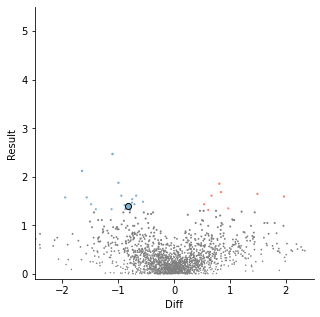

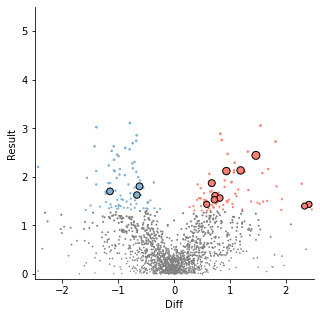

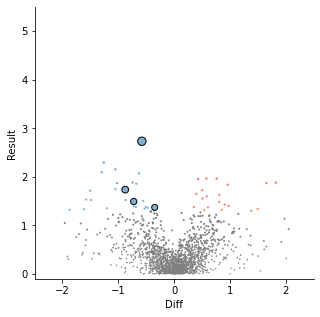

In [11]:
for i in pp['Molecular_Subtype'].unique():
    sig_c1 = dpres[i].dropna()[[]]
    sig_c1['Diff'] = dpres[i].dropna()['Diff']
    sig_c1['Result'] = dpres[i].dropna()['Result']
    sig_c1['GENE'] = dpres[i].dropna()['SYMBOL']

    def color(df):    
        return 1*(df['Result']<0.05)*(df['Diff']>0.0) - 1*(df['Result']<0.05)*(df['Diff']<-0.0) 

    print(i)
    print('Red:',(sig_c1.apply(color, axis=1)==1).sum(),'Blue:',(sig_c1.apply(color, axis=1)==-1).sum())
    print('BRCA genes. Red:',(sig_c1.loc[sig_c1['GENE'].apply(check_related)].apply(color, axis=1)==1).sum(),\
          'Blue:',(sig_c1.loc[sig_c1['GENE'].apply(check_related)].apply(color, axis=1)==-1).sum())
    print()
    
    plt.subplots(figsize=[5,5])

    sns.scatterplot(sig_c1['Diff'],\
                    -1*sig_c1['Result'].apply(np.log10),\
                    c=sig_c1.apply(color, axis=1).map({0:'grey',-1:sns.color_palette("Set3")[4],1:sns.color_palette("Set3")[3],}),linewidth=0,\
                   s=2-2*sig_c1['Result'].apply(np.log10))

    sns.scatterplot(sig_c1[sig_c1['GENE'].apply(check_related)][sig_c1.apply(color, axis=1)!=0]['Diff'],\
                    -1*sig_c1[sig_c1['GENE'].apply(check_related)][sig_c1.apply(color, axis=1)!=0]['Result'].apply(np.log10),\
                    color=sig_c1[sig_c1['GENE'].apply(check_related)][sig_c1.apply(color, axis=1)!=0].apply(color, axis=1).map({0:'grey',-1:sns.color_palette("Set3")[4],1:sns.color_palette("Set3")[3],}),linewidth=1,edgecolor='black',\
                    s=2-25*sig_c1[sig_c1['GENE'].apply(check_related)][sig_c1.apply(color, axis=1)!=0]['Result'].apply(np.log10))
    sns.despine(left=False, bottom=False, right=True, top=True)

    plt.xlim([-2.5,2.5])
    plt.ylim([-0.1,5.5])
    plt.savefig('../figures/phos_'+str(i)+'.pdf')

In [12]:
res_csv = pp.drop(columns='pCR	Molecular_Subtype'.split('\t')).T[[]]
for i in dpres['NegNeg'].columns[1:]:
    tmp = dpres['NegNeg'].copy()
    tmp.index = tmp['SYMBOL']
    res_csv[i+'.TNBC'] = res_csv.index.map(tmp[i])
    tmp = dpres['PosNeg'].copy()
    tmp.index = tmp['SYMBOL']
    res_csv[i+'.ER-HER2+'] = res_csv.index.map(tmp[i])
    tmp = dpres['PosPos'].copy()
    tmp.index = tmp['SYMBOL']
    res_csv[i+'.ER+HER2+'] = res_csv.index.map(tmp[i])
    
correct_dict = {}
for i in res_csv.index[res_csv.index.str.contains('-Sep|-Mar')]:
    correct_dict[i] = i.split('-')[1].upper()+i.split('-')[0]
res_csv = res_csv.rename(correct_dict, axis=0)
res_csv.columns = res_csv.columns.str.replace('Ctr','RD').str.replace('Case','pCR')
res_csv.sort_index().to_csv('../result/DEPPs.csv')
res_csv.sort_index()

ID,Mean_pCR.TNBC,Mean_pCR.ER-HER2+,Mean_pCR.ER+HER2+,Mean_RD.TNBC,Mean_RD.ER-HER2+,Mean_RD.ER+HER2+,Diff.TNBC,Diff.ER-HER2+,Diff.ER+HER2+,Result.TNBC,Result.ER-HER2+,Result.ER+HER2+
AAAS,24.398791,24.233664,24.434476,24.145853,24.729681,23.960442,0.252938,-0.496016,0.474034,0.441940,0.661930,0.054246
AAK1,26.332343,26.367096,26.292007,26.787779,26.226128,26.471664,-0.455436,0.140968,-0.179657,0.069916,0.758315,0.552214
ABCA1,21.452488,21.061564,20.988851,21.413002,21.948282,20.953335,0.039486,-0.886718,0.035516,0.350464,0.038182,0.691886
ABCC1,23.321482,22.815827,22.045844,22.128748,22.178324,21.946270,1.192734,0.637503,0.099574,0.007357,0.486202,0.872561
ABCC4,22.870754,22.945217,21.895896,23.204176,22.417826,22.257563,-0.333423,0.527391,-0.361667,0.973711,0.549043,0.719928
...,...,...,...,...,...,...,...,...,...,...,...,...
ZNHIT6,23.471016,22.923487,23.417181,22.930445,21.660328,22.903093,0.540570,1.263158,0.514088,0.084603,0.140563,0.385351
ZNRF2,24.380461,24.603996,24.681132,24.172288,24.817316,24.509684,0.208173,-0.213321,0.171449,0.895131,0.884119,0.939829
ZRANB2,26.660701,25.850899,26.796262,26.857990,26.092643,26.516302,-0.197289,-0.241744,0.279960,0.322852,0.987079,0.850318
ZRSR2,21.284219,19.850390,21.024704,20.853223,20.520032,20.527231,0.430996,-0.669642,0.497473,0.509847,0.783081,0.230790


In [13]:
i='PosPos'

pd.concat([

    dpres[i].loc[dpres[i]['SYMBOL'].apply(check_related)&\
             (dpres[i]['Diff']<0)&\
             (dpres[i]['Result']<0.05)].sort_values('Result')[:3],
    dpres[i].loc[dpres[i]['SYMBOL'].apply(check_related)&\
             (dpres[i]['Result']<0.05)].sort_values('Diff')[:3],
    
    dpres[i].loc[dpres[i]['SYMBOL'].apply(check_related)&\
             (dpres[i]['Diff']>0)&\
             (dpres[i]['Result']<0.05)].sort_values('Result')[:3],
    dpres[i].loc[dpres[i]['SYMBOL'].apply(check_related)&\
             (dpres[i]['Result']<0.05)].sort_values('Diff')[-3:],
    
])

,SYMBOL,Mean_Case,Mean_Ctr,Diff,Result
129,CTNND1,24.882312,25.459819,-0.577507,0.001847
896,USP20,23.404470,24.279719,-0.875249,0.018329
117,CTNNA1,25.402578,26.126169,-0.723591,0.032202
896,USP20,23.404470,24.279719,-0.875249,0.018329
117,CTNNA1,25.402578,26.126169,-0.723591,0.032202
129,CTNND1,24.882312,25.459819,-0.577507,0.001847
117,CTNNA1,25.402578,26.126169,-0.723591,0.032202
129,CTNND1,24.882312,25.459819,-0.577507,0.001847
207,FBLN1,24.710328,25.057665,-0.347337,0.042493


In [14]:
i='PosNeg'

pd.concat([

    dpres[i].loc[dpres[i]['SYMBOL'].apply(check_related)&\
             (dpres[i]['Diff']<0)&\
             (dpres[i]['Result']<0.05)].sort_values('Result')[:3],
    dpres[i].loc[dpres[i]['SYMBOL'].apply(check_related)&\
             (dpres[i]['Result']<0.05)].sort_values('Diff')[:3],
    
    dpres[i].loc[dpres[i]['SYMBOL'].apply(check_related)&\
             (dpres[i]['Diff']>0)&\
             (dpres[i]['Result']<0.05)].sort_values('Result')[:3],
    dpres[i].loc[dpres[i]['SYMBOL'].apply(check_related)&\
             (dpres[i]['Result']<0.05)].sort_values('Diff')[-3:],
    
])

,SYMBOL,Mean_Case,Mean_Ctr,Diff,Result
1525,FBXO4,22.21916,23.045413,-0.826253,0.039715
1525,FBXO4,22.21916,23.045413,-0.826253,0.039715
1525,FBXO4,22.21916,23.045413,-0.826253,0.039715


In [15]:
i='NegNeg'

pd.concat([

    dpres[i].loc[dpres[i]['SYMBOL'].apply(check_related)&\
             (dpres[i]['Diff']<0)&\
             (dpres[i]['Result']<0.05)].sort_values('Result')[:3],
    dpres[i].loc[dpres[i]['SYMBOL'].apply(check_related)&\
             (dpres[i]['Result']<0.05)].sort_values('Diff')[:3],
    
    dpres[i].loc[dpres[i]['SYMBOL'].apply(check_related)&\
             (dpres[i]['Diff']>0)&\
             (dpres[i]['Result']<0.05)].sort_values('Result')[:3],
    dpres[i].loc[dpres[i]['SYMBOL'].apply(check_related)&\
             (dpres[i]['Result']<0.05)].sort_values('Diff')[-3:],
    dpres[i].loc[dpres[i]['SYMBOL']=='MKI67']
    
])

,SYMBOL,Mean_Case,Mean_Ctr,Diff,Result
716,IRS1,22.379238,22.998770,-0.619532,0.015666
875,HIC1,23.289550,24.437568,-1.148019,0.019873
302,HSPB1,30.107765,30.773752,-0.665987,0.023646
875,HIC1,23.289550,24.437568,-1.148019,0.019873
302,HSPB1,30.107765,30.773752,-0.665987,0.023646
716,IRS1,22.379238,22.998770,-0.619532,0.015666
104,TOP2A,25.456791,23.989327,1.467464,0.003604
1401,ABCC1,23.321482,22.128748,1.192734,0.007357
147,MDC1,24.548993,23.612253,0.936740,0.007602
104,TOP2A,25.456791,23.989327,1.467464,0.003604


In [16]:
i='NegNeg'
pd.merge(deres[i].loc[deres[i]['SYMBOL'].apply(check_related)&\
             (deres[i]['Diff'].apply(abs)>1)&\
             (deres[i]['Result']<0.05)],
        dpres[i].loc[dpres[i]['SYMBOL'].apply(check_related)&\
             (dpres[i]['Diff'].apply(abs)>1)&\
             (dpres[i]['Result']<0.05)],
        on='SYMBOL', how='inner')

,SYMBOL,Mean_Case_x,Mean_Ctr_x,Diff_x,Result_x,Mean_Case_y,Mean_Ctr_y,Diff_y,Result_y
0,TOP2A,14.921605,13.551122,1.370484,0.001501,25.456791,23.989327,1.467464,0.003604


In [17]:
i='PosNeg'
pd.merge(deres[i].loc[deres[i]['SYMBOL'].apply(check_related)&\
             (deres[i]['Diff'].apply(abs)>1)&\
             (deres[i]['Result']<0.05)],
        dpres[i].loc[dpres[i]['SYMBOL'].apply(check_related)&\
             (dpres[i]['Diff'].apply(abs)>1)&\
             (dpres[i]['Result']<0.05)],
        on='SYMBOL', how='inner')

,SYMBOL,Mean_Case_x,Mean_Ctr_x,Diff_x,Result_x,Mean_Case_y,Mean_Ctr_y,Diff_y,Result_y


In [18]:
i='PosPos'
pd.merge(deres[i].loc[deres[i]['SYMBOL'].apply(check_related)&\
             (deres[i]['Diff'].apply(abs)>1)&\
             (deres[i]['Result']<0.05)],
        dpres[i].loc[dpres[i]['SYMBOL'].apply(check_related)&\
             (dpres[i]['Diff'].apply(abs)>1)&\
             (dpres[i]['Result']<0.05)],
        on='SYMBOL', how='inner')

,SYMBOL,Mean_Case_x,Mean_Ctr_x,Diff_x,Result_x,Mean_Case_y,Mean_Ctr_y,Diff_y,Result_y


In [19]:
import seaborn as sns
from statannot import add_stat_annotation
from itertools import combinations

def swarmplot_anno(x=None, y=None, hue=None, data=None, order=None, hue_order=None,\
                   dodge=False, orient=None, color=None, palette=None, size=5,\
                   edgecolor='gray', linewidth=0, ax=None, cmp_x=True, **kwargs):
    
    ax = sns.swarmplot(x=x, y=y, hue=hue, data=data, order=order, hue_order=hue_order,\
                       dodge=dodge, orient=orient, color=color, palette=palette, size=size,\
                       edgecolor=edgecolor, linewidth=linewidth, ax=ax, **kwargs)
    ax = sns.boxplot(x=x, y=y, hue=hue, color='white')

    add_stat_annotation(ax, x=x, y=y, hue=hue,
                        box_pairs=(((i, k) for k in j) for j in combinations(hue.dropna().unique(),2) for i in x.dropna().unique()),
                        test='Mann-Whitney', text_format='simple', loc='inside', \
                        comparisons_correction=None , verbose=0)
    if cmp_x:
        add_stat_annotation(ax, x=x, y=y,
                            box_pairs=(i for i in combinations(x.dropna().unique(),2)),
                            test='Mann-Whitney', text_format='simple', loc='outside', \
                            comparisons_correction=None , verbose=0)
    
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.get_legend().remove()

(-4.2, 4.2)

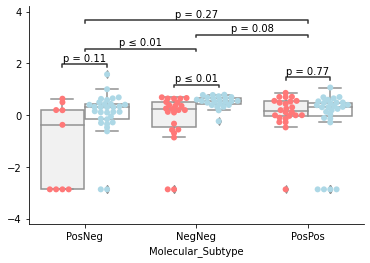

In [20]:
swarmplot_anno(dia['Molecular_Subtype'],st.zscore(dia['TOP2A']),dia['pCR'],\
               dodge=1, palette={0:'#ff7878',1:'lightblue'}, s=6, cmp_x=1)
plt.yticks([-4,-2,0,2,4])
plt.ylim([-4.2,4.2])

(-4.2, 4.2)

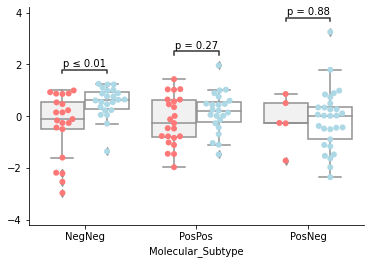

In [21]:
swarmplot_anno(dia[dia['TOP2A']!=0]['Molecular_Subtype'],st.zscore(dia[dia['TOP2A']!=0]['TOP2A']),dia['pCR'],\
               dodge=1, palette={0:'#ff7878',1:'lightblue'}, s=6, cmp_x=0)
plt.yticks([-4,-2,0,2,4])
plt.ylim([-4.2,4.2])

(-4.2, 4.2)

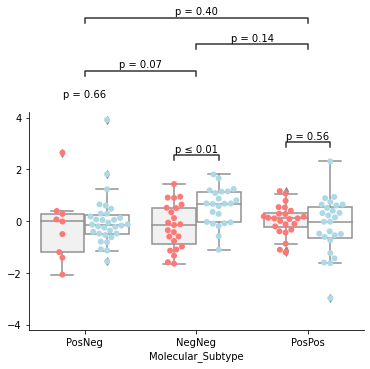

In [22]:
swarmplot_anno(pp['Molecular_Subtype'],st.zscore(pp['TOP2A']),pp['pCR'],\
               dodge=1, palette={0:'#ff7878',1:'lightblue'}, s=6, cmp_x=1)
plt.yticks([-4,-2,0,2,4])
plt.ylim([-4.2,4.2])

(-4.2, 4.2)

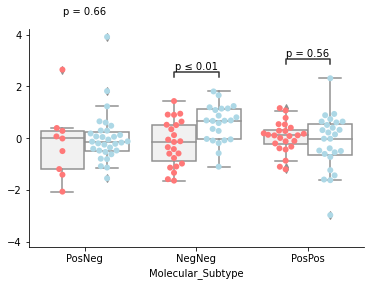

In [23]:
swarmplot_anno(pp[pp['TOP2A']!=0]['Molecular_Subtype'],st.zscore(pp[pp['TOP2A']!=0]['TOP2A']),pp['pCR'],\
               dodge=1, palette={0:'#ff7878',1:'lightblue'}, s=6, cmp_x=0)
plt.yticks([-4,-2,0,2,4])
plt.ylim([-4.2,4.2])